네이버 영화리뷰 감성분석
=======
네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus 데이터셋을 활용하여 한국어 텍스트의 감정분석을 진행해 보기    
https://github.com/e9t/nsmc    

< 프로젝트 진행 순서 >

1. 데이터 준비와 확인
2. 데이터로더 구성
3. 모델구성을 위한 데이터 분석 및 가공
4. 모델구성 및 validation set 구성
5. 모델 훈련 개시
6. Loss, Accuracy 그래프 시각화
7. 학습된 Embedding 레이어 분석
8. 한국어 Word2Vec 임베딩 활용하여 성능개선    
    -한국어 Word2Vec : https://github.com/Kyubyong/wordvectors

-21.10.28-

# 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 읽어보기 
train_data = pd.read_table('~/aiffel/Exploration/E7/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Exploration/E7/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


<AxesSubplot:>

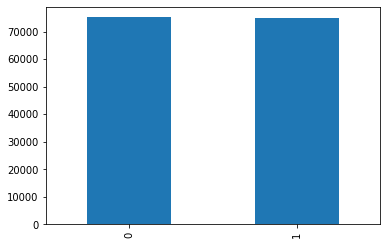

In [3]:
# train_data의 라벨 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [4]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  75173
1      1  74827


- 레이블이 비슷하지만 0인 리뷰가 근소하게 많습니다. 

In [5]:
# train_data의 NULL 개수 확인
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


- NULL 값은 데이터로더에서 처리해 줍니다. 

# 2. 데이터로더 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. data_loader 안에서는 다음을 수행해야 합니다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴


In [6]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    ## 데이터의 중복 제거 & NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    ## 한국어 토크나이저로 토큰화 & 불용어(Stopwords) 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    ## 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    ## 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    ## X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(len(X_train), len(X_test))

단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성됩니다.

- konlpy.tag 의 Mecab Class : MeCab-ko 형태학 분석기용 래퍼    
    https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/#mecab-class    
    -morphs(phrase) : 구문을 형태소로 구문 분석
- pandas.DataFrame.drop_duplicates() : subset으로 지정한 컬럼의 중복값 제거      
    https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
- pandas.DataFrame.dropna(how='any') : NA 값이 있으면 해당 행이나 열을 삭제     
    https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
- numpy.concatenate : 기존 축을 따라 배열 시퀀스를 결합    
    https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
- collections 의 Container datatypes : 해시 가능한 개체를 계산하기 위한 dict의 하위 클래스    
    https://docs.python.org/3/library/collections.html#collections.Counter    
    -counter.most_common(n) : n개의 가장 일반적인 요소 의 목록 과 가장 일반적인 것부터 가장 적은 것까지의 개수를 반환 
    -word_to_index는 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어 있습니다.

In [7]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
index_to_word[0]

'<PAD>'

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작함
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [16]:
# encode된 텍스트가 정상적으로 decode되는지 확인
print(train_data['document'][0])
print(get_encoded_sentence(train_data['document'][0],word_to_index))
sentence = get_encoded_sentence(train_data['document'][0],word_to_index)
print(get_decoded_sentence(sentence, index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더빙.. 진짜 짜증나네요 목소리
[1, 32, 2, 39, 2, 748]
아 <UNK> 진짜 <UNK> 목소리
라벨:  0


# 3. 모델구성을 위한 데이터 분석 및 가공

1) 데이터셋 내 문장 길이 분포    
2) 적절한 최대 문장 길이 지정    
3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가    

## 1) 데이터셋 내 문장 길이 분포 확인

In [17]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


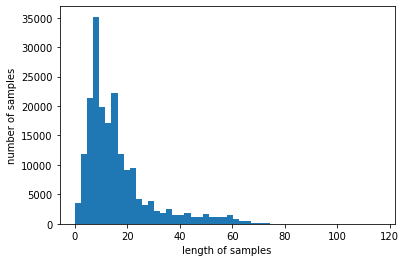

In [18]:
# 문장 길이 분포 확인
plt.hist([len(tokens) for tokens in total_data_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 2) 적절한 최대 문장 길이 지정

In [21]:
# 최대 길이를 (평균 + 2.3*표준편차)로 지정한다면,  
max_tokens = np.mean(num_tokens) + 2.3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  45
전체 문장의 0.946190980807724%가 maxlen 설정값 이내에 포함됩니다. 


## 3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [22]:
## 패딩 적용
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 45)
(49157, 45)


- 위에서 구한 maxlen=45 을 적용해줍니다.
- padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생합니다. 

# 4. 딥러닝 모델 설계와 훈련 및 validation set 구성


- validation set 구성    
Validation set(검정 데이터)은 training set으로 만들어진 모델의 성능을 측정하기 위해 사용된다. 일반적으로 어떤 모델이 가장 데이터에 적합한지 찾아내기 위해서 다양한 파라미터와 모델을 사용해보게 되며, 그 중 validation set으로 가장 성능이 좋았던 모델을 선택한다.    
(https://modern-manual.tistory.com/19)

- train/validation loss, accuracy 확인    
model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.
     
1) RNN 모델     
2) 1-D CNN 모델    
3) GlobalMaxPooling1D() 레이어 하나만 사용하는 모델    

## validation set 구성

In [23]:
# train set 100000건 분리
partial_x_train = X_train[:100000]  
partial_y_train = y_train[:100000]

# train set을 제외한 나머지 validation set
x_val = X_train[100000:]   
y_val = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(100000, 45)
(100000,)
(46182, 45)
(46182,)


## 1) RNN 모델 

텍스트 데이터를 다루는 데 주로 사용되는 딥러닝 모델은 바로 Recurrent Neural Network(RNN)입니다. RNN은 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델로 알려져 있습니다.

### 모델 설계

In [58]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 8로 
rnn_model.add(keras.layers.Dense(8, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [59]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보기

rnn_history = rnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 5s 14ms/step - loss: 0.6269 - accuracy: 0.6855 - val_loss: 0.3865 - val_accuracy: 0.8342
Epoch 2/20
196/196 [==============================] - 2s 12ms/step - loss: 0.3526 - accuracy: 0.8557 - val_loss: 0.3597 - val_accuracy: 0.8445
Epoch 3/20
196/196 [==============================] - 2s 12ms/step - loss: 0.3179 - accuracy: 0.8706 - val_loss: 0.3563 - val_accuracy: 0.8462
Epoch 4/20
196/196 [==============================] - 2s 12ms/step - loss: 0.3014 - accuracy: 0.8783 - val_loss: 0.3579 - val_accuracy: 0.8468
Epoch 5/20
196/196 [==============================] - 2s 12ms/step - loss: 0.2899 - accuracy: 0.8842 - val_loss: 0.3617 - val_accuracy: 0.8457
Epoch 6/20
196/196 [==============================] - 2s 12ms/step - loss: 0.2843 - accuracy: 0.8856 - val_loss: 0.3618 - val_accuracy: 0.8462
Epoch 7/20
196/196 [==============================] - 2s 12ms/step - loss: 0.2753 - accuracy: 0.8899 - val_loss: 0.3726 - val_accuracy: 0.8408

### train/validation loss, accuracy 확인

In [26]:
rnn_history_dict = rnn_history.history
print(rnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


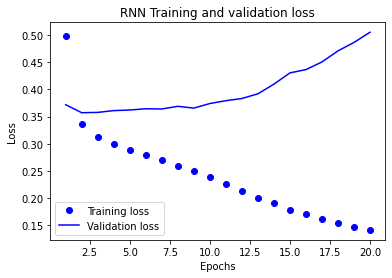

In [27]:
rnn_acc = rnn_history_dict['accuracy']
rnn_val_acc = rnn_history_dict['val_accuracy']
rnn_loss = rnn_history_dict['loss']
rnn_val_loss = rnn_history_dict['val_loss']

## Training loss & Validation loss 그래프 
epochs = range(1, len(rnn_acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, rnn_loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, rnn_val_loss, 'b', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

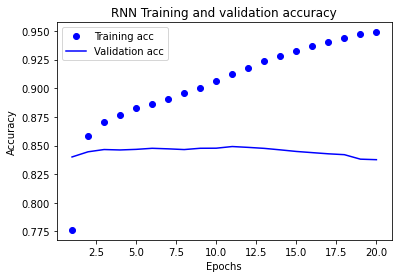

In [28]:
## Training accuracy & validation accuracy 그래프

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, rnn_acc, 'bo', label='Training acc')
plt.plot(epochs, rnn_val_acc, 'b', label='Validation acc')
plt.title('RNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가 

In [60]:
# word_vector_dim = 16 
rnn_results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(rnn_results)

1537/1537 - 5s - loss: 0.4888 - accuracy: 0.8346
[0.4887874722480774, 0.8345912098884583]


In [29]:
# word_vector_dim = 32 
rnn_results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(rnn_results)

1537/1537 - 5s - loss: 0.5042 - accuracy: 0.8382
[0.5042113661766052, 0.838212251663208]


- word_vector_dim을 16 썼을때 보다 32 썼을 때 accuracy가 조금 올라간 것을 볼 수 있다. 

## 2) 1-D CNN 모델

텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용할 수도 있습니다.    
1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됩니다. 이 방식도 텍스트를 처리하는 데 RNN 못지않은 효율을 보여줍니다.    
그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점이 있습니다.

### 모델 설계

In [61]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

cnn1d_model = keras.Sequential()
cnn1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn1d_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(keras.layers.MaxPooling1D(5))
cnn1d_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(keras.layers.GlobalMaxPooling1D())
cnn1d_model.add(keras.layers.Dense(8, activation='relu'))
cnn1d_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

cnn1d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

### 모델 학습

In [62]:
cnn1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보기

cnn1d_history = cnn1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 6s 19ms/step - loss: 0.6530 - accuracy: 0.5906 - val_loss: 0.4833 - val_accuracy: 0.7546
Epoch 2/20
196/196 [==============================] - 2s 9ms/step - loss: 0.4450 - accuracy: 0.7797 - val_loss: 0.4670 - val_accuracy: 0.7656
Epoch 3/20
196/196 [==============================] - 2s 9ms/step - loss: 0.4108 - accuracy: 0.7987 - val_loss: 0.4649 - val_accuracy: 0.7692
Epoch 4/20
196/196 [==============================] - 2s 9ms/step - loss: 0.3850 - accuracy: 0.8151 - val_loss: 0.4755 - val_accuracy: 0.7649
Epoch 5/20
196/196 [==============================] - 2s 9ms/step - loss: 0.3554 - accuracy: 0.8308 - val_loss: 0.4850 - val_accuracy: 0.7667
Epoch 6/20
196/196 [==============================] - 2s 9ms/step - loss: 0.3228 - accuracy: 0.8469 - val_loss: 0.5077 - val_accuracy: 0.7636
Epoch 7/20
196/196 [==============================] - 2s 9ms/step - loss: 0.2823 - accuracy: 0.8679 - val_loss: 0.5423 - val_accuracy: 0.7605
Epoch

### train/validation loss, accuracy 확인

In [32]:
cnn1d_history_dict = cnn1d_history.history
print(cnn1d_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


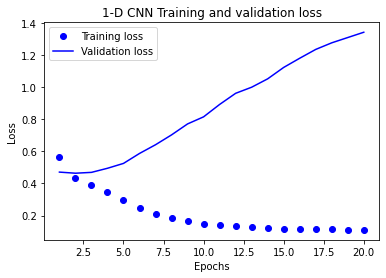

In [33]:
cnn1d_acc = cnn1d_history_dict['accuracy']
cnn1d_val_acc = cnn1d_history_dict['val_accuracy']
cnn1d_loss = cnn1d_history_dict['loss']
cnn1d_val_loss = cnn1d_history_dict['val_loss']

## Training loss & Validation loss 그래프 
epochs = range(1, len(cnn1d_acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, cnn1d_loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, cnn1d_val_loss, 'b', label='Validation loss')
plt.title('1-D CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

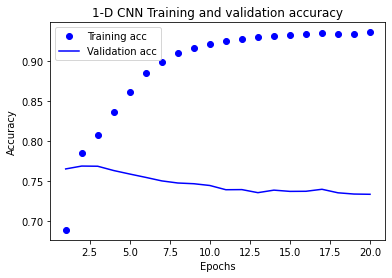

In [34]:
## Training accuracy & validation accuracy 그래프

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, cnn1d_acc, 'bo', label='Training acc')
plt.plot(epochs, cnn1d_val_acc, 'b', label='Validation acc')
plt.title('1-D CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가 

In [63]:
# word_vector_dim = 16
cnn1d_results = cnn1d_model.evaluate(X_test,  y_test, verbose=2)

print(cnn1d_results)

1537/1537 - 4s - loss: 1.1901 - accuracy: 0.7271
[1.1901416778564453, 0.7270988821983337]


In [36]:
# word_vector_dim = 32
cnn1d_results = cnn1d_model.evaluate(X_test,  y_test, verbose=2)

print(cnn1d_results)

1537/1537 - 3s - loss: 1.3464 - accuracy: 0.7288
[1.34640634059906, 0.728787362575531]


- word_vector_dim을 16 썼을때 보다 32 썼을 때 accuracy가 조금 올라간 것을 볼 수 있다. 
- 하지만 애초에 loss가 너무 큰 모델인 것 같다. 

## 3) GlobalMaxPooling1D() 레이어 하나만 사용하는 모델 

이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있습니다.

### 모델 설계

In [64]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

gmp1d_model = keras.Sequential()
gmp1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp1d_model.add(keras.layers.GlobalMaxPooling1D())
gmp1d_model.add(keras.layers.Dense(8, activation='relu'))
gmp1d_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

gmp1d_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [65]:
gmp1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gmp1d_history = gmp1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 2s 7ms/step - loss: 0.6662 - accuracy: 0.6826 - val_loss: 0.4911 - val_accuracy: 0.8006
Epoch 2/20
196/196 [==============================] - 1s 7ms/step - loss: 0.4332 - accuracy: 0.8267 - val_loss: 0.3821 - val_accuracy: 0.8305
Epoch 3/20
196/196 [==============================] - 1s 6ms/step - loss: 0.3438 - accuracy: 0.8554 - val_loss: 0.3649 - val_accuracy: 0.8397
Epoch 4/20
196/196 [==============================] - 1s 7ms/step - loss: 0.3081 - accuracy: 0.8712 - val_loss: 0.3610 - val_accuracy: 0.8425
Epoch 5/20
196/196 [==============================] - 1s 6ms/step - loss: 0.2820 - accuracy: 0.8839 - val_loss: 0.3630 - val_accuracy: 0.8442
Epoch 6/20
196/196 [==============================] - 1s 7ms/step - loss: 0.2631 - accuracy: 0.8923 - val_loss: 0.3685 - val_accuracy: 0.8436
Epoch 7/20
196/196 [==============================] - 1s 7ms/step - loss: 0.2459 - accuracy: 0.9017 - val_loss: 0.3759 - val_accuracy: 0.8434
Epoch 

### train/validation loss, accuracy 확인

In [66]:
gmp1d_history_dict = gmp1d_history.history
print(gmp1d_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


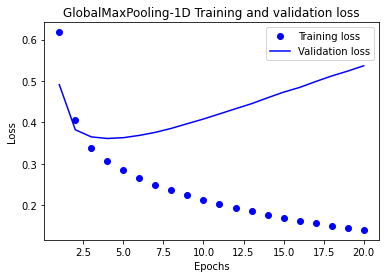

In [67]:
gmp1d_acc = gmp1d_history_dict['accuracy']
gmp1d_val_acc = gmp1d_history_dict['val_accuracy']
gmp1d_loss = gmp1d_history_dict['loss']
gmp1d_val_loss = gmp1d_history_dict['val_loss']

## Training loss & Validation loss 그래프 
epochs = range(1, len(gmp1d_acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, gmp1d_loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, gmp1d_val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling-1D Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

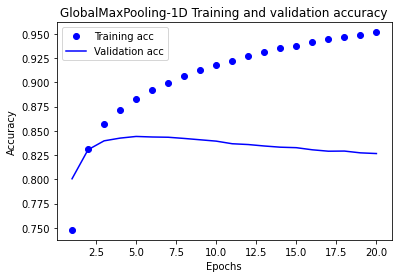

In [68]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, gmp1d_acc, 'bo', label='Training acc')
plt.plot(epochs, gmp1d_val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling-1D Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가

In [69]:
# word_vector_dim = 16
results = gmp1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5445 - accuracy: 0.8218
[0.5445311665534973, 0.8217548131942749]


In [43]:
# word_vector_dim = 32
results = gmp1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7180 - accuracy: 0.8205
[0.7180452942848206, 0.8204935193061829]


- word_vector_dim을 16 썼을때 보다 32 썼을 때 accuracy가 더 떨어지고 loss도 많이 커진 것을 볼 수 있다. 

# 5. 학습된 Embedding 레이어 분석

gensim을 활용하여 자체학습된 임베딩 레이어를 분석해본다. 

## 1) RNN 

In [44]:
rnn_embedding_layer = rnn_model.layers[0]
rnn_weights = rnn_embedding_layer.get_weights()[0]
print(rnn_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [45]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
rnn_word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration/E7/data/rnn_word2vec.txt'
f = open(rnn_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
rnn_vectors = rnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
f.close()

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

rnn_word_vectors = Word2VecKeyedVectors.load_word2vec_format(rnn_word2vec_file_path, binary=False)
vector = rnn_word_vectors['사랑']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([-0.06678939,  0.13236834, -0.15419503,  0.14574748, -0.08810258,
       -0.04910444, -0.20529374, -0.07102077,  0.19097614,  0.03787336,
       -0.1555728 ,  0.20897174,  0.02597507,  0.27731884, -0.10851872,
        0.07266102,  0.09065792, -0.04030541,  0.09827105,  0.19364063,
        0.04615596, -0.24710336, -0.07784062, -0.18978855, -0.0763343 ,
        0.31283435, -0.07756382, -0.0618914 , -0.16501717,  0.12769033,
        0.14998756,  0.0016737 ], dtype=float32)

- gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

In [47]:
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하기
rnn_word_vectors.similar_by_word("사랑")

[('깨끗', 0.9375412464141846),
 ('갑옷', 0.9263908267021179),
 ('밋', 0.9229751825332642),
 ('졌으면', 0.9189354181289673),
 ('재미있', 0.913223922252655),
 ('즐겁', 0.9128591418266296),
 ('재밌', 0.9053227305412292),
 ('률', 0.9004949927330017),
 ('아파', 0.8978623747825623),
 ('명작', 0.8970028162002563)]

## 2) 1-D CNN

In [48]:
cnn1d_embedding_layer = cnn1d_model.layers[0]
cnn1d_weights = cnn1d_embedding_layer.get_weights()[0]
print(cnn1d_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
cnn1d_word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration/E7/data/cnn1d_word2vec.txt'
f = open(cnn1d_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
cnn1d_vectors = cnn1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(cnn1d_vectors[i, :])))))
f.close()

In [50]:
cnn1d_word_vectors = Word2VecKeyedVectors.load_word2vec_format(cnn1d_word2vec_file_path, binary=False)
vector = cnn1d_word_vectors['사랑']
vector

array([ 0.01489828, -0.07304773, -0.09796191,  0.0496802 ,  0.07193971,
        0.03551134,  0.02534965, -0.15432781,  0.03836785, -0.0881504 ,
        0.00579021, -0.0695053 , -0.00055073, -0.12415516, -0.05962562,
        0.08752721, -0.00483787, -0.08407322,  0.04397834,  0.04210342,
        0.11492377,  0.00684064, -0.0956311 ,  0.07370058, -0.00887471,
        0.04621385,  0.02258993, -0.00990182,  0.09820917,  0.06224319,
        0.01945491,  0.07048359], dtype=float32)

In [51]:
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하기
cnn1d_word_vectors.similar_by_word("사랑")

[('온전히', 0.7341041564941406),
 ('샤', 0.7270454168319702),
 ('오싹', 0.7248449921607971),
 ('알차', 0.7161033153533936),
 ('감자', 0.7104562520980835),
 ('진가', 0.7082674503326416),
 ('스무', 0.7058520913124084),
 ('주몽', 0.7047841548919678),
 ('모처럼', 0.7043222784996033),
 ('시린', 0.7033970355987549)]

## 3) GlobalMaxPooling1D() 

In [52]:
gmp1d_embedding_layer = gmp1d_model.layers[0]
gmp1d_weights = gmp1d_embedding_layer.get_weights()[0]
print(gmp1d_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [53]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
gmp1d_word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration/E7/data/gmp1d_word2vec.txt'
f = open(gmp1d_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
gmp1d_vectors = gmp1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(gmp1d_vectors[i, :])))))
f.close()

In [54]:
gmp1d_word_vectors = Word2VecKeyedVectors.load_word2vec_format(gmp1d_word2vec_file_path, binary=False)
vector = gmp1d_word_vectors['사랑']
vector

array([ 0.10343802, -0.03453527, -0.02031648, -0.1540111 ,  0.07651448,
       -0.02064647, -0.17408194,  0.06167801,  0.06492566,  0.01853982,
       -0.20873782,  0.10677142, -0.0580065 ,  0.07432534, -0.21562982,
       -0.19893126,  0.09369016, -0.19799136, -0.20002355, -0.19939853,
        0.14311278, -0.06098884, -0.07469507, -0.19478165, -0.1671773 ,
        0.09293634, -0.21164992, -0.18419792, -0.09357188,  0.03162838,
        0.01553064, -0.17931332], dtype=float32)

In [55]:
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하기
gmp1d_word_vectors.similar_by_word("사랑")

[('몇', 0.7287728786468506),
 ('라면', 0.6559146046638489),
 ('정신없이', 0.6502580046653748),
 ('죽이', 0.6416970491409302),
 ('김상경', 0.6382197737693787),
 ('스릴', 0.6368194818496704),
 ('픈', 0.6348060369491577),
 ('나중', 0.6286488771438599),
 ('엘리베이터', 0.6270647644996643),
 ('영화제', 0.6265848875045776)]

- 세가지 모델 모두 사랑이라는 단어와 유사한 다른 단어를 그리 잘 찾았다고 느껴지지 않습니다. 감성분류 태스크를 잠깐 학습한 것만으로 워드 벡터가 유의미하게 학습되기는 어려운 것 같습니다. 우리가 다룬 정도의 훈련데이터로는 워드 벡터를 정교하게 학습시키기 어렵습니다.

# 5. Word2Vec

https://radimrehurek.com/gensim/models/word2vec.html

In [56]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = X_train, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py", line 1155, in _worker_loop
    tally, raw_tally = self._do_train_job(data_iterable, alpha, thread_private_mem)
  File "/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py", line 946, in _do_train_job
    tally += train_batch_cbow(self, sentences, alpha, work, neu1, self.compute_loss)
  File "gensim/models/word2vec_inner.pyx", line 638, in gensim.models.word2vec_inner.train_batch_cbow
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self

KeyboardInterrupt: 

In [ ]:
model.wv.vectors.shape

# 회고

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.    
RNN, 1-D CNN, GlobalMaxPooling1D 세가지 모델로 감성분석 학습 및 평가를 진행하였습니다. 모두 같은 word_to_index 딕셔너리를 사용하고, train과 validation set을 약 2:1 비율로 사용하였습니다. 또한 워드 벡터의 차원 수를 16와 32 로, epoch는 20으로 각각 진행해 보았습니다.  


2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.     
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩을 분석하였습니다. 하지만 세 모델 모두 성능이 그렇게 좋지 않음을 확인하였습니다. 


3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.    
네이버 영화리뷰 데이터에서 한국어 Word2Vec 을 활용하는 방법을 잘 몰라서 감성분석 정확도를 85% 이상 달성하지 못하였습니다. 이 부분을 좀 더 공부해야 할 것 같습니다. 